# Project part A

Imports

In [2]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = [10, 8]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

## Downloading the data

In [7]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_category_pages(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=1000"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    categories_list = wikitext_json["query"]["categorymembers"]

    return categories_list

def get_wiki_data(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    pages_content_list = wikitext_json["query"]["pages"]

    return pages_content_list

def get_wiki_pages_with_prefix(prefix, namespace_id):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=allpages"
    dataformat ="format=json&aplimit=500"
    apprefix = "apprefix=" + urllib.parse.quote_plus(prefix)
    apnamespace = "apnamespace=" + str(namespace_id)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, apprefix, apnamespace, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    title_list_raw = wikitext_json["query"]["allpages"]

    if len(title_list_raw) > 0:
        title_list = [entry["title"] for entry in title_list_raw]
    else:
        title_list = []

    return title_list

def parse_page(page, graph):

    # Does page exist?
    if "revisions" in page:
        content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
        title = page["title"]

        # Normalize whitespace
        content = re.sub(r'[\n\t\ ]+', ' ', content)

        # Retreive links to User: pages
        links = re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content) # Previous: '\[([^\]\[\|:]+)[\]\|]'
        filtered_links = np.unique(links)

        # Heuristic for Archive pages
        #archive_number = re.findall('\|\s*counter\s*=\s*([^\|\}\s]+)', content)

        origin_title_list = re.findall('([^/]+).*', title)
        if len(origin_title_list) > 0:
            origin_title = origin_title_list[0]
        else:
            origin_title = title

        # Add User: links to graph
        count = 0
        if origin_title in graph:
            for link in filtered_links:
                if link not in graph:
                    graph.add_node(link, page_class="user")
                graph.add_edge(link, origin_title)
                count += 1
        else:
            print(origin_title) # Talk:HIV for some reason
        
        # Article word count
        #word_count = len(re.findall('\w+', content.lower()))
        #graph.nodes(data=True)[title]["word_count"] = word_count

        return count
    else:
        return 0

def scrape_wiki(category_titles):
    # Params
    wiki_api_page_request_limit = 50
    namespace_id_talk = 1

    # Get pages in category
    titles = []
    for category_title in tqdm(category_titles, desc="Fetching category page titles"):
        pages = get_category_pages(category_title)
        titles += [r["title"] for r in pages]

    # Filter only Talk pages
    filtered_titles = [title for title in titles if "Talk:" in title] # Todo might be worth using regex here

    # Graph
    page_graph = nx.DiGraph()
    for page in filtered_titles:
        page_graph.add_node(page, page_class="talk")

    # Find archive pages
    archive_titles = []
    for title in tqdm(filtered_titles, desc="Fetching archive page titles"):
        curr_archive_titles = get_wiki_pages_with_prefix(title.replace("Talk:", "") + "/Archive", namespace_id_talk)
        archive_titles += curr_archive_titles

    all_titles = filtered_titles + archive_titles

    print("Total pages to parse: " + str(len(all_titles)))

    # Split list because of API limits
    split_titles_list = list(chunks(all_titles, wiki_api_page_request_limit))

    results = []
    for sublist in tqdm(split_titles_list, desc="Parsing page batches"):
        titlestr = "|".join(sublist)
        pages_contents = get_wiki_data(titlestr)
        curr_results = [parse_page(page_content, page_graph) for key, page_content in pages_contents.items()]
        results += curr_results

    print(results)

    return page_graph


category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph = scrape_wiki(category_titles)

Fetching category page titles:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching archive page titles:   0%|          | 0/600 [00:00<?, ?it/s]

Total pages to parse: 4767


Parsing page batches:   0%|          | 0/96 [00:00<?, ?it/s]

Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
Talk:HIV
[9, 5, 3, 9, 15, 9, 6, 6, 3, 11, 5, 26, 17, 1, 5, 16, 7, 9, 1, 4, 8, 11, 28, 6, 1, 5, 22, 7, 6, 9, 17, 4, 8, 17, 3, 2, 2, 17, 12, 10, 4, 11, 9, 0, 5, 3, 6, 2, 7, 7, 4, 3, 7, 3, 9, 6, 6, 13, 8, 30, 13, 13, 24, 14, 5, 42, 6, 4, 2, 12, 6, 4, 7, 6, 4, 3, 15, 22, 0, 4, 6, 13, 3, 17, 3, 15, 6, 9, 3, 5, 8, 2, 13, 4, 0, 4, 2, 4, 6, 10, 16, 3, 12, 5, 9, 34, 4, 15, 7, 4, 1, 27, 12, 5, 11, 1, 1, 5, 0, 10, 2, 9, 7, 4, 4, 14, 1, 7, 5, 30, 4, 4, 4, 8, 1, 8, 3, 8, 6, 11, 24, 0, 24, 2, 22, 1, 1, 12, 20, 3, 7, 4, 8, 19, 4, 1, 4, 3, 0, 9, 26, 3, 9, 20, 2, 28, 13, 4, 23, 8, 1, 3, 4, 20, 8, 8, 34, 25, 6, 7, 35, 6, 12, 8, 7, 16, 7, 11, 30, 16, 0, 5, 2, 8, 4, 8, 14, 5, 7, 4, 6, 39, 0, 2, 18, 46, 0, 8, 2, 0, 22, 2, 8, 42, 9, 20, 7, 20, 6, 2, 5, 19, 20, 9, 12, 5, 1, 8, 5, 9, 9, 3

/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  fun

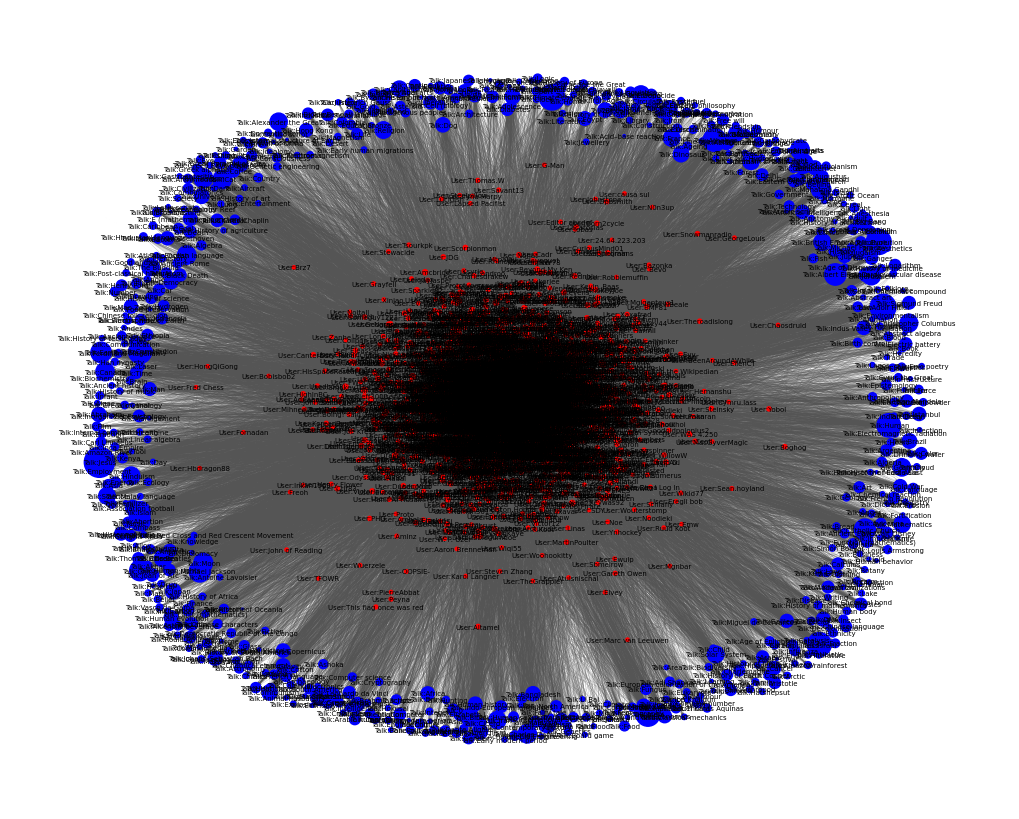

In [6]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 5:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

## Basic Analysis

## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)
> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)
> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?